<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Search-trajectory-files-and-create-output-path" data-toc-modified-id="Search-trajectory-files-and-create-output-path-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Search trajectory files and create output path</a></span></li><li><span><a href="#Plot-experiment-trajectories" data-toc-modified-id="Plot-experiment-trajectories-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot experiment trajectories</a></span></li><li><span><a href="#Processing-Experiments" data-toc-modified-id="Processing-Experiments-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Processing Experiments</a></span></li><li><span><a href="#Interactive-plot-of-density-images" data-toc-modified-id="Interactive-plot-of-density-images-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Interactive plot of density images</a></span></li><li><span><a href="#Aggregate-unfiltered-density-distributions" data-toc-modified-id="Aggregate-unfiltered-density-distributions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Aggregate unfiltered density distributions</a></span></li><li><span><a href="#Filter-50/50-distributions" data-toc-modified-id="Filter-50/50-distributions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filter 50/50 distributions</a></span></li><li><span><a href="#Aggregate-filtered-density-distributions" data-toc-modified-id="Aggregate-filtered-density-distributions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Aggregate filtered density distributions</a></span></li><li><span><a href="#Plot-density-maps-to-file" data-toc-modified-id="Plot-density-maps-to-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plot density maps to file</a></span></li></ul></div>

In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as matplot
import itertools
import math
import sys

from tqdm import tqdm_notebook, tqdm
from os import listdir, mkdir
from os.path import join, isdir
from ipywidgets import *
from multiprocessing import Pool, Lock

module_path = os.path.abspath(os.path.join('../python/python_src_preprocessing/src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import preprocessing.preprocessing as processing
import plotting.densitymap as plot

%load_ext autoreload
%autoreload 1
%aimport preprocessing.preprocessing, plotting.densitymap

%matplotlib notebook

# Search trajectory files and create output path

In [2]:
# paramter
input_path = 'KO/'
output_path = 'check/csvs/experiment'
experiments = [
    'ko-240-050-240',
    'ko-240-060-240',
    'ko-240-080-240',
    'ko-240-100-240',
    'ko-240-120-240',
    'ko-240-150-240',
    'ko-240-240-240',
    # 'ko-300-050-300',
    # 'ko-300-080-300',
    # 'ko-300-120-300',
    # 'ko-300-150-300'
]

if not isdir(output_path):
    mkdir(output_path)

In [3]:
# helper functions

def toInch(pixel, dpi=92):
    return pixel / dpi


def plot_experiment(frame, ax):
    # map p-ids to targets
    for pId, group in frame.groupby('pedestrianId'):
        ax.plot(group['x'], group['y'], zorder=1)

    rect = matplot.Rectangle(
        (-2.4, 3), 2.4, 1, edgecolor='r', alpha=1, fill=False, zorder=2, linewidth=2)

    ax.add_patch(rect)
    ax.grid()
    

def load_experiment(folder, key):
    files = list(filter(lambda file: key in file, listdir(folder)))
    
    if len(files) == 0:
        return None
    
    data = pd.read_csv(
        join(folder, files[0]), 
        sep=' ', 
        names=['pedestrianId', 'timeStep', 'x', 'y', 'e'], 
        index_col=False, 
        header=None, 
        skiprows=0)
        
    data['x'] = data['x'] / 100
    data['y'] = data['y'] / 100
    
    print('loaded', files[0])
    
    return files[0], data


# Plot experiment trajectories

loaded ko-240-050-240_combined_MB.txt
loaded ko-240-060-240_combined_MB.txt
loaded ko-240-080-240_combined_MB.txt
loaded ko-240-100-240_combined_MB.txt
loaded ko-240-120-240_combined_MB.txt
loaded ko-240-150-240_combined_MB.txt
loaded ko-240-240-240_combined_MB.txt


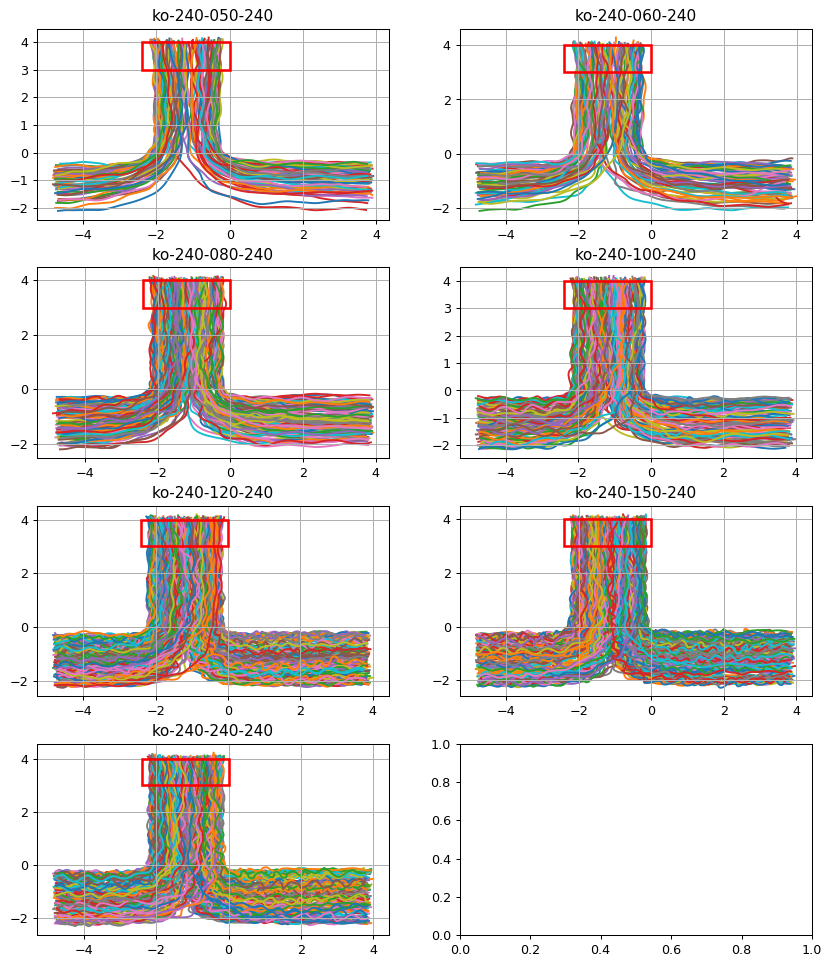

In [4]:
# plot all scenario trajectories to file
plots = len(experiments)
rows = math.ceil(plots / 2.0)
fig, ax = matplot.subplots(nrows=rows, ncols=2, figsize=(
    toInch(1000), toInch(rows * 300)), dpi=92)

ax = np.array(ax).flatten()

for idx in range(plots):
    experiment = experiments[idx]
    ax[idx].set_title(experiment)

    _, frame = load_experiment(join(input_path, experiment), 'combined')
    plot_experiment(frame, ax[idx])

fig.subplots_adjust(hspace=0.25)
fig.savefig('experiment-scenario-trajectories.pdf', transparent=True)

# Processing Experiments

In [4]:
# processing experiments

results = []
for experiment in tqdm_notebook(experiments, desc='process files'):
    directory = os.path.dirname(experiment)
    
    filename, frame = load_experiment(join(input_path, experiment), 'combined')
    name = filename[:filename.index('.')]
    
    if os.path.exists(join(output_path, name + '.csv')):
        print('skipping', name)
        continue
    
    context = dict({
        'name': name,
        'targets': ['A', 'B'],
        'area':  [-2.4, 3, 2.4, 1],
        'exact': True,
        'sigma': 0.7,
        'resolution': 0.1,
        'pedestrian_radius': 0.195,
        'gauss_bounds': 2,
        'pId2Target': processing.juelich_assign_target,
        'filters': [
            # preprocessing.juelich_filter_percentiles,
        ],
        'processors': [
            processing.process_densities,
            processing.process_pedestrians,
            processing.process_percentiles
        ],
        'number_of_cores': 5,
        'skip': 1
    })
    context = processing.process_experiment(frame, context)
    results.append(context)

    densities = np.array(context.get('densities'))
    # sort densities by timestep number
    densities = densities[densities[:,0].argsort()]
    with open(join(output_path, name + '.csv'), mode='w') as file:
        for density in densities:
            file.write(
                ';'.join(map(lambda r: "{:.10f}".format(r), density[1:])) + '\n')

        file.flush()
    

loaded ko-240-050-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1000 , # of total timesteps 1000 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:45<00:00, 22.01it/s]


loaded ko-240-060-240_combined_MB.txt
using every  1 timestep, # of used timesteps 942 , # of total timesteps 942 image size (10, 24)


100%|████████████████████████████████████████████████████████████████████████████████| 942/942 [00:41<00:00, 10.86it/s]


loaded ko-240-080-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1157 , # of total timesteps 1157 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1157/1157 [01:13<00:00,  7.92it/s]


loaded ko-240-100-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1033 , # of total timesteps 1033 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1033/1033 [00:59<00:00,  8.02it/s]


loaded ko-240-120-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1511 , # of total timesteps 1511 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1511/1511 [02:09<00:00,  5.79it/s]


loaded ko-240-150-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1426 , # of total timesteps 1426 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1426/1426 [01:58<00:00,  5.82it/s]


loaded ko-240-240-240_combined_MB.txt
using every  1 timestep, # of used timesteps 1414 , # of total timesteps 1414 image size (10, 24)


100%|██████████████████████████████████████████████████████████████████████████████| 1414/1414 [01:56<00:00,  6.01it/s]


# Interactive plot of density images
<font color='red' size='5'><b>Important note:</b><br/>This requires that the result of the processed files (cell above) is still available</font>

In [ ]:
# interactive density maps
%matplotlib notebook

def extrac_xy(pedestrians, x0, y0, resolution):
    x = []
    y = []

    for _, ped in pedestrians.iterrows():
        x.append(int(abs(ped['x'] - x0) * (1 / resolution)))
        y.append(int(abs(ped['y'] - y0) * (1 / resolution)))

    return x, y

for result in results:
    name = result.get('name')
    densities = result.get('densities')
    area = result.get('area')
    peds = result.get('pedestrians')
    size = result.get('size')
    res = result.get('resolution')
    t = len(result.get('targets'))

    start = 0

    first = densities[start][:-t].reshape(size)

    fig, ax = matplot.subplots()

    cbar = None

    ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
    ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2,
                        1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

    ax.set_yticks(np.linspace(0, len(first) - 1, 6))
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    def update(frame):
        global cbar
        f = densities[frame][:-t].reshape(size)

        ax.clear()
        if cbar is not None:
            cbar.remove()

        img = ax.imshow(f, interpolation='Nearest')
        cbar = fig.colorbar(img)

        x, y = extrac_xy(peds[frame], area[0], area[1], res)

        ax.plot(x, y, '.r', markersize=10)

        ax.set_xticks(np.linspace(0, len(first[0]) - 1, 13))
        ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0,
                            1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])

        ax.set_yticks(np.linspace(0, len(first) - 1, 6))
        ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])

    interact(update, frame=widgets.IntSlider(
        min=0, max=len(densities)-1, step=1, value=start))

    break

# Aggregate unfiltered density distributions

In [7]:
# aggregate distributions


# output_p = 'juelich-vadere/output_01_save/'
outputs = list(filter(lambda o: 'filtered' not in o, os.listdir(output_path)))
dfs = []
for output in tqdm_notebook(outputs, desc="loading output files", total=len(outputs)):
    dfs.append(pd.read_csv(os.path.join(
        output_path, output), sep=';', header=None))

frame = pd.concat([df.iloc[:, -2:] for df in dfs], sort=False)
display(frame.groupby(list(frame.columns), as_index=False).size().to_frame(
    'frames').reset_index())

,240,241,frames
0,0.000000,1.000000,1372
1,0.166667,0.833333,11
2,0.200000,0.800000,45
3,0.250000,0.750000,294
4,0.285714,0.714286,3
5,0.333333,0.666667,881
6,0.400000,0.600000,517
7,0.428571,0.571429,20
8,0.500000,0.500000,2241
9,0.571429,0.428571,23


# Filter 50/50 distributions

In [8]:
# filter every second 50% 50% distribution

outputs = list(filter(lambda o: o.endswith('.csv') and 'filtered' not in o, os.listdir(output_path)))

for output in tqdm_notebook(outputs, desc="filter density distributions"):
    skip = True
    skipped = 0
    written = 0
    with open(os.path.join(output_path, output), "r") as full:
        with open(os.path.join(output_path, output[:-4] + '_filtered.csv'), "w") as filtered:
            for line in full:
                if line.strip().endswith('0.5000000000;0.5000000000;0.0000000000'):
                    skip = not(skip)
                    
                    if skip:
                        skipped = skipped + 1
                        continue
                
                filtered.write(line)
                written = written + 1

    print(written, 'lines written,', skipped, 'lines skipped')

861 lines written, 0 lines skipped
803 lines written, 0 lines skipped
1064 lines written, 0 lines skipped
955 lines written, 0 lines skipped
1420 lines written, 0 lines skipped
1364 lines written, 0 lines skipped
1330 lines written, 0 lines skipped



# Aggregate filtered density distributions

In [9]:
# aggregate distributions

# output_p = 'juelich-vadere/output_01_save/'
outputs = list(filter(lambda o: 'filtered' in o, os.listdir(output_path)))
dfs = []
for output in tqdm_notebook(outputs, desc="loading output files", total=len(outputs)):
    dfs.append(pd.read_csv(os.path.join(
        output_path, output), sep=';', header=None))

frame = pd.concat([df.iloc[:, -2:] for df in dfs], sort=False)
display(frame.groupby(list(frame.columns), as_index=False).size().to_frame(
    'frames').reset_index())

,240,241,frames
0,0.000000,1.000000,1372
1,0.166667,0.833333,11
2,0.200000,0.800000,45
3,0.250000,0.750000,294
4,0.285714,0.714286,3
5,0.333333,0.666667,881
6,0.400000,0.600000,517
7,0.428571,0.571429,20
8,0.500000,0.500000,2241
9,0.571429,0.428571,23


# Plot density maps to file

In [10]:
# save density maps

image_directory = "check/images/"

if not os.path.isdir(image_directory):
    os.mkdir(image_directory)

def filter_chunk(chunk):
    return chunk.loc[(chunk[231] == 0.5) & (chunk[232] == 0.5)]
    
outputs = list(filter(lambda o: 'filtered' in o, os.listdir(output_path)))
for output in tqdm_notebook(outputs):
    print(output)
    plot.processFile(output, output_path, image_directory) # , _filter=filter_chunk
    

ko-240-050-240_combined_MB_filtered.csv


Done ko-240-050-240_combined_MB_filtered.csv
ko-240-060-240_combined_MB_filtered.csv


Done ko-240-060-240_combined_MB_filtered.csv
ko-240-080-240_combined_MB_filtered.csv


Done ko-240-080-240_combined_MB_filtered.csv
ko-240-100-240_combined_MB_filtered.csv


Done ko-240-100-240_combined_MB_filtered.csv
ko-240-120-240_combined_MB_filtered.csv


Done ko-240-120-240_combined_MB_filtered.csv
ko-240-150-240_combined_MB_filtered.csv


Done ko-240-150-240_combined_MB_filtered.csv
ko-240-240-240_combined_MB_filtered.csv


Done ko-240-240-240_combined_MB_filtered.csv

